<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_with_mixup_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_duration104weeks_ra_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_control_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.6 MB/s eta 0:00:00


In [10]:
batch_size=128
epochs = 200
lr = 4.5e-5
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.45
attn_drop_rate=0.35
drop_path_rate=0.35
mixup_alpha=0.5
#optimizer's_settings(AdamW)
weight_decay=1e-4
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=100
T_mult=2
eta_min=1e-6

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(
    224,
    scale=(0.75, 1.0),
    ratio=(0.9, 1.1)
),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)
"""
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1000
)"""

"\nscheduler = torch.optim.lr_scheduler.OneCycleLR(\n    optimizer,\n    max_lr=1e-5,\n    epochs=epochs,\n    steps_per_epoch=len(train_loader),\n    pct_start=0.1,\n    anneal_strategy='cos',\n    div_factor=25,\n    final_div_factor=1000\n)"

学習ループを設定し、実行していく

In [11]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model

def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-11-ad02b673bba0>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-11-ad02b673bba0>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 1 - train_loss : 0.7300 - train_acc: 0.5097 - val_loss : 0.7502 - val_acc: 0.4949 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7485 - test_acc: 0.5000 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 0.7631 - train_acc: 0.5183 - val_loss : 0.7160 - val_acc: 0.4949 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7158 - test_acc: 0.5000 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 0.6923 - train_acc: 0.5732 - val_loss : 0.6963 - val_acc: 0.4949 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.6983 - test_acc: 0.5000 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 0.6936 - train_acc: 0.5340 - val_loss : 0.6900 - val_acc: 0.4747 - val_sensitivity: 0.1200 - val_specificity: 0.8367 - val_f1: 0.1875 - test_loss : 0.6919 - test_acc: 0.5000 - test_sensitivity: 0.1111 - test_specificity: 0.8889 - test_f1: 0.1818



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 0.6905 - train_acc: 0.5627 - val_loss : 0.6875 - val_acc: 0.5657 - val_sensitivity: 0.3600 - val_specificity: 0.7755 - val_f1: 0.4557 - test_loss : 0.6897 - test_acc: 0.5000 - test_sensitivity: 0.2778 - test_specificity: 0.7222 - test_f1: 0.3571



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 0.6936 - train_acc: 0.5495 - val_loss : 0.6866 - val_acc: 0.5758 - val_sensitivity: 0.3400 - val_specificity: 0.8163 - val_f1: 0.4474 - test_loss : 0.6888 - test_acc: 0.5000 - test_sensitivity: 0.2778 - test_specificity: 0.7222 - test_f1: 0.3571



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 7 - train_loss : 0.6805 - train_acc: 0.6205 - val_loss : 0.6860 - val_acc: 0.5051 - val_sensitivity: 0.1600 - val_specificity: 0.8571 - val_f1: 0.2462 - test_loss : 0.6880 - test_acc: 0.5278 - test_sensitivity: 0.1667 - test_specificity: 0.8889 - test_f1: 0.2609



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 8 - train_loss : 0.6882 - train_acc: 0.5529 - val_loss : 0.6857 - val_acc: 0.5051 - val_sensitivity: 0.1000 - val_specificity: 0.9184 - val_f1: 0.1695 - test_loss : 0.6873 - test_acc: 0.5000 - test_sensitivity: 0.0556 - test_specificity: 0.9444 - test_f1: 0.1000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 9 - train_loss : 0.6788 - train_acc: 0.5899 - val_loss : 0.6855 - val_acc: 0.4949 - val_sensitivity: 0.0400 - val_specificity: 0.9592 - val_f1: 0.0741 - test_loss : 0.6870 - test_acc: 0.5278 - test_sensitivity: 0.0556 - test_specificity: 1.0000 - test_f1: 0.1053



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 10 - train_loss : 0.6872 - train_acc: 0.5221 - val_loss : 0.6845 - val_acc: 0.4949 - val_sensitivity: 0.0400 - val_specificity: 0.9592 - val_f1: 0.0741 - test_loss : 0.6865 - test_acc: 0.5278 - test_sensitivity: 0.0556 - test_specificity: 1.0000 - test_f1: 0.1053



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 11 - train_loss : 0.6935 - train_acc: 0.5462 - val_loss : 0.6822 - val_acc: 0.4949 - val_sensitivity: 0.0600 - val_specificity: 0.9388 - val_f1: 0.1071 - test_loss : 0.6849 - test_acc: 0.5278 - test_sensitivity: 0.1111 - test_specificity: 0.9444 - test_f1: 0.1905



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 12 - train_loss : 0.6782 - train_acc: 0.5754 - val_loss : 0.6791 - val_acc: 0.5657 - val_sensitivity: 0.2200 - val_specificity: 0.9184 - val_f1: 0.3385 - test_loss : 0.6826 - test_acc: 0.5833 - test_sensitivity: 0.2222 - test_specificity: 0.9444 - test_f1: 0.3478



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 13 - train_loss : 0.6776 - train_acc: 0.5919 - val_loss : 0.6756 - val_acc: 0.6566 - val_sensitivity: 0.4800 - val_specificity: 0.8367 - val_f1: 0.5854 - test_loss : 0.6799 - test_acc: 0.5278 - test_sensitivity: 0.2778 - test_specificity: 0.7778 - test_f1: 0.3704



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 14 - train_loss : 0.6742 - train_acc: 0.5756 - val_loss : 0.6728 - val_acc: 0.6263 - val_sensitivity: 0.5200 - val_specificity: 0.7347 - val_f1: 0.5843 - test_loss : 0.6783 - test_acc: 0.5833 - test_sensitivity: 0.4444 - test_specificity: 0.7222 - test_f1: 0.5161



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 15 - train_loss : 0.6628 - train_acc: 0.6427 - val_loss : 0.6704 - val_acc: 0.6263 - val_sensitivity: 0.5200 - val_specificity: 0.7347 - val_f1: 0.5843 - test_loss : 0.6771 - test_acc: 0.5833 - test_sensitivity: 0.4444 - test_specificity: 0.7222 - test_f1: 0.5161



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 16 - train_loss : 0.6528 - train_acc: 0.6774 - val_loss : 0.6686 - val_acc: 0.6566 - val_sensitivity: 0.5000 - val_specificity: 0.8163 - val_f1: 0.5952 - test_loss : 0.6768 - test_acc: 0.5556 - test_sensitivity: 0.3333 - test_specificity: 0.7778 - test_f1: 0.4286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 17 - train_loss : 0.6744 - train_acc: 0.6039 - val_loss : 0.6681 - val_acc: 0.6364 - val_sensitivity: 0.4400 - val_specificity: 0.8367 - val_f1: 0.5500 - test_loss : 0.6774 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 18 - train_loss : 0.6765 - train_acc: 0.6222 - val_loss : 0.6689 - val_acc: 0.6162 - val_sensitivity: 0.3400 - val_specificity: 0.8980 - val_f1: 0.4722 - test_loss : 0.6788 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 19 - train_loss : 0.6672 - train_acc: 0.5993 - val_loss : 0.6700 - val_acc: 0.5758 - val_sensitivity: 0.2600 - val_specificity: 0.8980 - val_f1: 0.3824 - test_loss : 0.6807 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 20 - train_loss : 0.6760 - train_acc: 0.5804 - val_loss : 0.6684 - val_acc: 0.6061 - val_sensitivity: 0.3200 - val_specificity: 0.8980 - val_f1: 0.4507 - test_loss : 0.6804 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 21 - train_loss : 0.6557 - train_acc: 0.6313 - val_loss : 0.6637 - val_acc: 0.6566 - val_sensitivity: 0.4200 - val_specificity: 0.8980 - val_f1: 0.5526 - test_loss : 0.6779 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 22 - train_loss : 0.6637 - train_acc: 0.6284 - val_loss : 0.6602 - val_acc: 0.6566 - val_sensitivity: 0.4400 - val_specificity: 0.8776 - val_f1: 0.5641 - test_loss : 0.6761 - test_acc: 0.5556 - test_sensitivity: 0.2778 - test_specificity: 0.8333 - test_f1: 0.3846



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 23 - train_loss : 0.6465 - train_acc: 0.6491 - val_loss : 0.6600 - val_acc: 0.6566 - val_sensitivity: 0.4400 - val_specificity: 0.8776 - val_f1: 0.5641 - test_loss : 0.6769 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 24 - train_loss : 0.6308 - train_acc: 0.6996 - val_loss : 0.6606 - val_acc: 0.6566 - val_sensitivity: 0.4200 - val_specificity: 0.8980 - val_f1: 0.5526 - test_loss : 0.6785 - test_acc: 0.5000 - test_sensitivity: 0.1667 - test_specificity: 0.8333 - test_f1: 0.2500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 25 - train_loss : 0.6369 - train_acc: 0.6865 - val_loss : 0.6646 - val_acc: 0.5758 - val_sensitivity: 0.2600 - val_specificity: 0.8980 - val_f1: 0.3824 - test_loss : 0.6836 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 26 - train_loss : 0.6320 - train_acc: 0.6945 - val_loss : 0.6676 - val_acc: 0.5758 - val_sensitivity: 0.2400 - val_specificity: 0.9184 - val_f1: 0.3636 - test_loss : 0.6882 - test_acc: 0.5278 - test_sensitivity: 0.1111 - test_specificity: 0.9444 - test_f1: 0.1905



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 27 - train_loss : 0.6702 - train_acc: 0.6087 - val_loss : 0.6608 - val_acc: 0.6061 - val_sensitivity: 0.3200 - val_specificity: 0.8980 - val_f1: 0.4507 - test_loss : 0.6844 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 28 - train_loss : 0.6563 - train_acc: 0.6299 - val_loss : 0.6528 - val_acc: 0.6768 - val_sensitivity: 0.4600 - val_specificity: 0.8980 - val_f1: 0.5897 - test_loss : 0.6787 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 29 - train_loss : 0.6538 - train_acc: 0.6437 - val_loss : 0.6514 - val_acc: 0.6970 - val_sensitivity: 0.5000 - val_specificity: 0.8980 - val_f1: 0.6250 - test_loss : 0.6782 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 30 - train_loss : 0.6492 - train_acc: 0.6643 - val_loss : 0.6510 - val_acc: 0.6970 - val_sensitivity: 0.5000 - val_specificity: 0.8980 - val_f1: 0.6250 - test_loss : 0.6788 - test_acc: 0.5278 - test_sensitivity: 0.2222 - test_specificity: 0.8333 - test_f1: 0.3200



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 31 - train_loss : 0.6092 - train_acc: 0.7490 - val_loss : 0.6534 - val_acc: 0.6667 - val_sensitivity: 0.4400 - val_specificity: 0.8980 - val_f1: 0.5714 - test_loss : 0.6822 - test_acc: 0.5278 - test_sensitivity: 0.1667 - test_specificity: 0.8889 - test_f1: 0.2609



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 32 - train_loss : 0.6351 - train_acc: 0.6742 - val_loss : 0.6590 - val_acc: 0.6162 - val_sensitivity: 0.3200 - val_specificity: 0.9184 - val_f1: 0.4571 - test_loss : 0.6888 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 33 - train_loss : 0.6542 - train_acc: 0.6354 - val_loss : 0.6633 - val_acc: 0.5859 - val_sensitivity: 0.2600 - val_specificity: 0.9184 - val_f1: 0.3881 - test_loss : 0.6941 - test_acc: 0.5278 - test_sensitivity: 0.1111 - test_specificity: 0.9444 - test_f1: 0.1905



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 34 - train_loss : 0.6442 - train_acc: 0.6300 - val_loss : 0.6633 - val_acc: 0.5859 - val_sensitivity: 0.2600 - val_specificity: 0.9184 - val_f1: 0.3881 - test_loss : 0.6950 - test_acc: 0.5278 - test_sensitivity: 0.1111 - test_specificity: 0.9444 - test_f1: 0.1905



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 35 - train_loss : 0.6037 - train_acc: 0.7384 - val_loss : 0.6608 - val_acc: 0.5960 - val_sensitivity: 0.2800 - val_specificity: 0.9184 - val_f1: 0.4118 - test_loss : 0.6936 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 36 - train_loss : 0.6152 - train_acc: 0.6924 - val_loss : 0.6594 - val_acc: 0.6162 - val_sensitivity: 0.3200 - val_specificity: 0.9184 - val_f1: 0.4571 - test_loss : 0.6938 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 37 - train_loss : 0.6732 - train_acc: 0.6333 - val_loss : 0.6525 - val_acc: 0.6566 - val_sensitivity: 0.4200 - val_specificity: 0.8980 - val_f1: 0.5526 - test_loss : 0.6880 - test_acc: 0.5278 - test_sensitivity: 0.1667 - test_specificity: 0.8889 - test_f1: 0.2609



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 38 - train_loss : 0.6420 - train_acc: 0.6750 - val_loss : 0.6538 - val_acc: 0.6263 - val_sensitivity: 0.3600 - val_specificity: 0.8980 - val_f1: 0.4932 - test_loss : 0.6902 - test_acc: 0.5278 - test_sensitivity: 0.1667 - test_specificity: 0.8889 - test_f1: 0.2609



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 39 - train_loss : 0.6626 - train_acc: 0.6138 - val_loss : 0.6567 - val_acc: 0.6162 - val_sensitivity: 0.3400 - val_specificity: 0.8980 - val_f1: 0.4722 - test_loss : 0.6937 - test_acc: 0.5556 - test_sensitivity: 0.1667 - test_specificity: 0.9444 - test_f1: 0.2727



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 40 - train_loss : 0.6327 - train_acc: 0.6910 - val_loss : 0.6540 - val_acc: 0.6263 - val_sensitivity: 0.3600 - val_specificity: 0.8980 - val_f1: 0.4932 - test_loss : 0.6911 - test_acc: 0.5278 - test_sensitivity: 0.1667 - test_specificity: 0.8889 - test_f1: 0.2609



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 41 - train_loss : 0.5791 - train_acc: 0.7663 - val_loss : 0.6514 - val_acc: 0.6465 - val_sensitivity: 0.4000 - val_specificity: 0.8980 - val_f1: 0.5333 - test_loss : 0.6892 - test_acc: 0.5556 - test_sensitivity: 0.2222 - test_specificity: 0.8889 - test_f1: 0.3333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 42 - train_loss : 0.5855 - train_acc: 0.7572 - val_loss : 0.6429 - val_acc: 0.6869 - val_sensitivity: 0.5000 - val_specificity: 0.8776 - val_f1: 0.6173 - test_loss : 0.6809 - test_acc: 0.5556 - test_sensitivity: 0.2778 - test_specificity: 0.8333 - test_f1: 0.3846



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 43 - train_loss : 0.6404 - train_acc: 0.6794 - val_loss : 0.6355 - val_acc: 0.7071 - val_sensitivity: 0.5600 - val_specificity: 0.8571 - val_f1: 0.6588 - test_loss : 0.6738 - test_acc: 0.6389 - test_sensitivity: 0.4444 - test_specificity: 0.8333 - test_f1: 0.5517



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 44 - train_loss : 0.6222 - train_acc: 0.7183 - val_loss : 0.6293 - val_acc: 0.7172 - val_sensitivity: 0.6400 - val_specificity: 0.7959 - val_f1: 0.6957 - test_loss : 0.6675 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 45 - train_loss : 0.6622 - train_acc: 0.6482 - val_loss : 0.6275 - val_acc: 0.7172 - val_sensitivity: 0.6400 - val_specificity: 0.7959 - val_f1: 0.6957 - test_loss : 0.6666 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 46 - train_loss : 0.6515 - train_acc: 0.6489 - val_loss : 0.6274 - val_acc: 0.7172 - val_sensitivity: 0.6400 - val_specificity: 0.7959 - val_f1: 0.6957 - test_loss : 0.6672 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 47 - train_loss : 0.6394 - train_acc: 0.6558 - val_loss : 0.6287 - val_acc: 0.7172 - val_sensitivity: 0.6400 - val_specificity: 0.7959 - val_f1: 0.6957 - test_loss : 0.6689 - test_acc: 0.6389 - test_sensitivity: 0.4444 - test_specificity: 0.8333 - test_f1: 0.5517



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 48 - train_loss : 0.5941 - train_acc: 0.7427 - val_loss : 0.6289 - val_acc: 0.7071 - val_sensitivity: 0.6200 - val_specificity: 0.7959 - val_f1: 0.6813 - test_loss : 0.6691 - test_acc: 0.6389 - test_sensitivity: 0.4444 - test_specificity: 0.8333 - test_f1: 0.5517



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 49 - train_loss : 0.6505 - train_acc: 0.6359 - val_loss : 0.6268 - val_acc: 0.7172 - val_sensitivity: 0.6400 - val_specificity: 0.7959 - val_f1: 0.6957 - test_loss : 0.6667 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 50 - train_loss : 0.6244 - train_acc: 0.6946 - val_loss : 0.6236 - val_acc: 0.6970 - val_sensitivity: 0.7000 - val_specificity: 0.6939 - val_f1: 0.7000 - test_loss : 0.6629 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 51 - train_loss : 0.6334 - train_acc: 0.6756 - val_loss : 0.6230 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6613 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 52 - train_loss : 0.6075 - train_acc: 0.7210 - val_loss : 0.6237 - val_acc: 0.7273 - val_sensitivity: 0.8400 - val_specificity: 0.6122 - val_f1: 0.7568 - test_loss : 0.6615 - test_acc: 0.6389 - test_sensitivity: 0.7222 - test_specificity: 0.5556 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 53 - train_loss : 0.6481 - train_acc: 0.6421 - val_loss : 0.6255 - val_acc: 0.7273 - val_sensitivity: 0.8600 - val_specificity: 0.5918 - val_f1: 0.7611 - test_loss : 0.6627 - test_acc: 0.6111 - test_sensitivity: 0.7778 - test_specificity: 0.4444 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 54 - train_loss : 0.6482 - train_acc: 0.6381 - val_loss : 0.6250 - val_acc: 0.7273 - val_sensitivity: 0.8600 - val_specificity: 0.5918 - val_f1: 0.7611 - test_loss : 0.6623 - test_acc: 0.6111 - test_sensitivity: 0.7778 - test_specificity: 0.4444 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 55 - train_loss : 0.5976 - train_acc: 0.7311 - val_loss : 0.6229 - val_acc: 0.7172 - val_sensitivity: 0.8400 - val_specificity: 0.5918 - val_f1: 0.7500 - test_loss : 0.6610 - test_acc: 0.6389 - test_sensitivity: 0.7222 - test_specificity: 0.5556 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 56 - train_loss : 0.6458 - train_acc: 0.6702 - val_loss : 0.6217 - val_acc: 0.7273 - val_sensitivity: 0.8400 - val_specificity: 0.6122 - val_f1: 0.7568 - test_loss : 0.6603 - test_acc: 0.6389 - test_sensitivity: 0.7222 - test_specificity: 0.5556 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 57 - train_loss : 0.6484 - train_acc: 0.6398 - val_loss : 0.6207 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6599 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 58 - train_loss : 0.5990 - train_acc: 0.7291 - val_loss : 0.6200 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6597 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 59 - train_loss : 0.5716 - train_acc: 0.7615 - val_loss : 0.6192 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6594 - test_acc: 0.6111 - test_sensitivity: 0.6111 - test_specificity: 0.6111 - test_f1: 0.6111



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 60 - train_loss : 0.6531 - train_acc: 0.6648 - val_loss : 0.6186 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6592 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 61 - train_loss : 0.6167 - train_acc: 0.6773 - val_loss : 0.6182 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6590 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 62 - train_loss : 0.6100 - train_acc: 0.7122 - val_loss : 0.6177 - val_acc: 0.7172 - val_sensitivity: 0.7800 - val_specificity: 0.6531 - val_f1: 0.7358 - test_loss : 0.6589 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 63 - train_loss : 0.6374 - train_acc: 0.6705 - val_loss : 0.6173 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6589 - test_acc: 0.6389 - test_sensitivity: 0.7222 - test_specificity: 0.5556 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 64 - train_loss : 0.6208 - train_acc: 0.6968 - val_loss : 0.6165 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6586 - test_acc: 0.6667 - test_sensitivity: 0.7222 - test_specificity: 0.6111 - test_f1: 0.6842



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 65 - train_loss : 0.6448 - train_acc: 0.6533 - val_loss : 0.6157 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6582 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 66 - train_loss : 0.6394 - train_acc: 0.6640 - val_loss : 0.6152 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6580 - test_acc: 0.6111 - test_sensitivity: 0.6111 - test_specificity: 0.6111 - test_f1: 0.6111



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 67 - train_loss : 0.6299 - train_acc: 0.6896 - val_loss : 0.6150 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6580 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 68 - train_loss : 0.6313 - train_acc: 0.6970 - val_loss : 0.6147 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6578 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 69 - train_loss : 0.6055 - train_acc: 0.7206 - val_loss : 0.6146 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6578 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 70 - train_loss : 0.6331 - train_acc: 0.6743 - val_loss : 0.6140 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6573 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 71 - train_loss : 0.5613 - train_acc: 0.7463 - val_loss : 0.6133 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6569 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 72 - train_loss : 0.6573 - train_acc: 0.6396 - val_loss : 0.6130 - val_acc: 0.7172 - val_sensitivity: 0.7800 - val_specificity: 0.6531 - val_f1: 0.7358 - test_loss : 0.6568 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 73 - train_loss : 0.5955 - train_acc: 0.7418 - val_loss : 0.6128 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6569 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 74 - train_loss : 0.5774 - train_acc: 0.7639 - val_loss : 0.6124 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6568 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 75 - train_loss : 0.6047 - train_acc: 0.7015 - val_loss : 0.6120 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6565 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 76 - train_loss : 0.6048 - train_acc: 0.6930 - val_loss : 0.6116 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6564 - test_acc: 0.6667 - test_sensitivity: 0.6667 - test_specificity: 0.6667 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 77 - train_loss : 0.5985 - train_acc: 0.7012 - val_loss : 0.6115 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6564 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 78 - train_loss : 0.5854 - train_acc: 0.7467 - val_loss : 0.6113 - val_acc: 0.7071 - val_sensitivity: 0.7400 - val_specificity: 0.6735 - val_f1: 0.7184 - test_loss : 0.6564 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 79 - train_loss : 0.6292 - train_acc: 0.6761 - val_loss : 0.6111 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6565 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 80 - train_loss : 0.5639 - train_acc: 0.7630 - val_loss : 0.6110 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6567 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 81 - train_loss : 0.6591 - train_acc: 0.6456 - val_loss : 0.6107 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6566 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 82 - train_loss : 0.5707 - train_acc: 0.7547 - val_loss : 0.6105 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6566 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 83 - train_loss : 0.6089 - train_acc: 0.7199 - val_loss : 0.6105 - val_acc: 0.6970 - val_sensitivity: 0.7200 - val_specificity: 0.6735 - val_f1: 0.7059 - test_loss : 0.6568 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 84 - train_loss : 0.5982 - train_acc: 0.7412 - val_loss : 0.6103 - val_acc: 0.7071 - val_sensitivity: 0.7200 - val_specificity: 0.6939 - val_f1: 0.7129 - test_loss : 0.6570 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 85 - train_loss : 0.5671 - train_acc: 0.7590 - val_loss : 0.6102 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6570 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 86 - train_loss : 0.5761 - train_acc: 0.7525 - val_loss : 0.6100 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6570 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 87 - train_loss : 0.6261 - train_acc: 0.7037 - val_loss : 0.6099 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6570 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 88 - train_loss : 0.6044 - train_acc: 0.7522 - val_loss : 0.6098 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 89 - train_loss : 0.5945 - train_acc: 0.7276 - val_loss : 0.6098 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 90 - train_loss : 0.6411 - train_acc: 0.6668 - val_loss : 0.6097 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 91 - train_loss : 0.5785 - train_acc: 0.7704 - val_loss : 0.6096 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 92 - train_loss : 0.5957 - train_acc: 0.7409 - val_loss : 0.6096 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 93 - train_loss : 0.6281 - train_acc: 0.7041 - val_loss : 0.6095 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 94 - train_loss : 0.6308 - train_acc: 0.6775 - val_loss : 0.6095 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6569 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 95 - train_loss : 0.6428 - train_acc: 0.6559 - val_loss : 0.6093 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6567 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 96 - train_loss : 0.6053 - train_acc: 0.7275 - val_loss : 0.6092 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6566 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 97 - train_loss : 0.6384 - train_acc: 0.6899 - val_loss : 0.6091 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6566 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 98 - train_loss : 0.6016 - train_acc: 0.7435 - val_loss : 0.6090 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6566 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 99 - train_loss : 0.6293 - train_acc: 0.6739 - val_loss : 0.6090 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6565 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 100 - train_loss : 0.6275 - train_acc: 0.6883 - val_loss : 0.6089 - val_acc: 0.7172 - val_sensitivity: 0.7200 - val_specificity: 0.7143 - val_f1: 0.7200 - test_loss : 0.6564 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 101 - train_loss : 0.6325 - train_acc: 0.6739 - val_loss : 0.6052 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6540 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 102 - train_loss : 0.5846 - train_acc: 0.7294 - val_loss : 0.6017 - val_acc: 0.7172 - val_sensitivity: 0.7800 - val_specificity: 0.6531 - val_f1: 0.7358 - test_loss : 0.6536 - test_acc: 0.6667 - test_sensitivity: 0.6667 - test_specificity: 0.6667 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 103 - train_loss : 0.6091 - train_acc: 0.7322 - val_loss : 0.6024 - val_acc: 0.7576 - val_sensitivity: 0.9000 - val_specificity: 0.6122 - val_f1: 0.7895 - test_loss : 0.6572 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 104 - train_loss : 0.6035 - train_acc: 0.7217 - val_loss : 0.6017 - val_acc: 0.7374 - val_sensitivity: 0.9000 - val_specificity: 0.5714 - val_f1: 0.7759 - test_loss : 0.6604 - test_acc: 0.6111 - test_sensitivity: 0.8333 - test_specificity: 0.3889 - test_f1: 0.6818



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 105 - train_loss : 0.6458 - train_acc: 0.6517 - val_loss : 0.6020 - val_acc: 0.7374 - val_sensitivity: 0.9000 - val_specificity: 0.5714 - val_f1: 0.7759 - test_loss : 0.6642 - test_acc: 0.5556 - test_sensitivity: 0.8333 - test_specificity: 0.2778 - test_f1: 0.6522



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 106 - train_loss : 0.6243 - train_acc: 0.6779 - val_loss : 0.6035 - val_acc: 0.7273 - val_sensitivity: 0.9000 - val_specificity: 0.5510 - val_f1: 0.7692 - test_loss : 0.6686 - test_acc: 0.5556 - test_sensitivity: 0.8333 - test_specificity: 0.2778 - test_f1: 0.6522



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 107 - train_loss : 0.6121 - train_acc: 0.7032 - val_loss : 0.6080 - val_acc: 0.7172 - val_sensitivity: 0.9000 - val_specificity: 0.5306 - val_f1: 0.7627 - test_loss : 0.6763 - test_acc: 0.5833 - test_sensitivity: 0.8889 - test_specificity: 0.2778 - test_f1: 0.6809



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 108 - train_loss : 0.5885 - train_acc: 0.7445 - val_loss : 0.5886 - val_acc: 0.7475 - val_sensitivity: 0.8800 - val_specificity: 0.6122 - val_f1: 0.7788 - test_loss : 0.6586 - test_acc: 0.5833 - test_sensitivity: 0.6667 - test_specificity: 0.5000 - test_f1: 0.6154



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 109 - train_loss : 0.6859 - train_acc: 0.6340 - val_loss : 0.5874 - val_acc: 0.7475 - val_sensitivity: 0.8800 - val_specificity: 0.6122 - val_f1: 0.7788 - test_loss : 0.6603 - test_acc: 0.5833 - test_sensitivity: 0.6667 - test_specificity: 0.5000 - test_f1: 0.6154



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 110 - train_loss : 0.6199 - train_acc: 0.6912 - val_loss : 0.6072 - val_acc: 0.7172 - val_sensitivity: 0.9000 - val_specificity: 0.5306 - val_f1: 0.7627 - test_loss : 0.6827 - test_acc: 0.5833 - test_sensitivity: 0.8889 - test_specificity: 0.2778 - test_f1: 0.6809



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 111 - train_loss : 0.6271 - train_acc: 0.6943 - val_loss : 0.5983 - val_acc: 0.7475 - val_sensitivity: 0.9000 - val_specificity: 0.5918 - val_f1: 0.7826 - test_loss : 0.6743 - test_acc: 0.6111 - test_sensitivity: 0.8333 - test_specificity: 0.3889 - test_f1: 0.6818



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 112 - train_loss : 0.6544 - train_acc: 0.6495 - val_loss : 0.5859 - val_acc: 0.7273 - val_sensitivity: 0.7200 - val_specificity: 0.7347 - val_f1: 0.7273 - test_loss : 0.6606 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 113 - train_loss : 0.6206 - train_acc: 0.7258 - val_loss : 0.5971 - val_acc: 0.7475 - val_sensitivity: 0.6600 - val_specificity: 0.8367 - val_f1: 0.7253 - test_loss : 0.6702 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 114 - train_loss : 0.6182 - train_acc: 0.6954 - val_loss : 0.5903 - val_acc: 0.7172 - val_sensitivity: 0.6800 - val_specificity: 0.7551 - val_f1: 0.7083 - test_loss : 0.6615 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 115 - train_loss : 0.6199 - train_acc: 0.6802 - val_loss : 0.5926 - val_acc: 0.7576 - val_sensitivity: 0.8600 - val_specificity: 0.6531 - val_f1: 0.7818 - test_loss : 0.6638 - test_acc: 0.5833 - test_sensitivity: 0.6667 - test_specificity: 0.5000 - test_f1: 0.6154



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 116 - train_loss : 0.5931 - train_acc: 0.7351 - val_loss : 0.6022 - val_acc: 0.7374 - val_sensitivity: 0.8800 - val_specificity: 0.5918 - val_f1: 0.7719 - test_loss : 0.6730 - test_acc: 0.5556 - test_sensitivity: 0.7222 - test_specificity: 0.3889 - test_f1: 0.6190



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 117 - train_loss : 0.6293 - train_acc: 0.6624 - val_loss : 0.5969 - val_acc: 0.7576 - val_sensitivity: 0.8800 - val_specificity: 0.6327 - val_f1: 0.7857 - test_loss : 0.6652 - test_acc: 0.5556 - test_sensitivity: 0.6667 - test_specificity: 0.4444 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 118 - train_loss : 0.6284 - train_acc: 0.6947 - val_loss : 0.5926 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6564 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 119 - train_loss : 0.5519 - train_acc: 0.7874 - val_loss : 0.5983 - val_acc: 0.7374 - val_sensitivity: 0.7000 - val_specificity: 0.7755 - val_f1: 0.7292 - test_loss : 0.6605 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 120 - train_loss : 0.6395 - train_acc: 0.6507 - val_loss : 0.5950 - val_acc: 0.7273 - val_sensitivity: 0.7000 - val_specificity: 0.7551 - val_f1: 0.7216 - test_loss : 0.6569 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 121 - train_loss : 0.6588 - train_acc: 0.6405 - val_loss : 0.5916 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6537 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 122 - train_loss : 0.5982 - train_acc: 0.7112 - val_loss : 0.5949 - val_acc: 0.7374 - val_sensitivity: 0.8400 - val_specificity: 0.6327 - val_f1: 0.7636 - test_loss : 0.6599 - test_acc: 0.5556 - test_sensitivity: 0.6667 - test_specificity: 0.4444 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 123 - train_loss : 0.6379 - train_acc: 0.6250 - val_loss : 0.5925 - val_acc: 0.7374 - val_sensitivity: 0.8400 - val_specificity: 0.6327 - val_f1: 0.7636 - test_loss : 0.6573 - test_acc: 0.5556 - test_sensitivity: 0.6667 - test_specificity: 0.4444 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 124 - train_loss : 0.6511 - train_acc: 0.6563 - val_loss : 0.5882 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6489 - test_acc: 0.7222 - test_sensitivity: 0.6667 - test_specificity: 0.7778 - test_f1: 0.7059



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 125 - train_loss : 0.5733 - train_acc: 0.7689 - val_loss : 0.5908 - val_acc: 0.7475 - val_sensitivity: 0.7200 - val_specificity: 0.7755 - val_f1: 0.7423 - test_loss : 0.6495 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 126 - train_loss : 0.6213 - train_acc: 0.6908 - val_loss : 0.5937 - val_acc: 0.7273 - val_sensitivity: 0.6800 - val_specificity: 0.7755 - val_f1: 0.7158 - test_loss : 0.6520 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 127 - train_loss : 0.6381 - train_acc: 0.6699 - val_loss : 0.5864 - val_acc: 0.7172 - val_sensitivity: 0.7400 - val_specificity: 0.6939 - val_f1: 0.7255 - test_loss : 0.6435 - test_acc: 0.7222 - test_sensitivity: 0.6667 - test_specificity: 0.7778 - test_f1: 0.7059



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 128 - train_loss : 0.6130 - train_acc: 0.7177 - val_loss : 0.5852 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6429 - test_acc: 0.6667 - test_sensitivity: 0.6667 - test_specificity: 0.6667 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 129 - train_loss : 0.6670 - train_acc: 0.6401 - val_loss : 0.5854 - val_acc: 0.7071 - val_sensitivity: 0.7800 - val_specificity: 0.6327 - val_f1: 0.7290 - test_loss : 0.6425 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 130 - train_loss : 0.6180 - train_acc: 0.6765 - val_loss : 0.5848 - val_acc: 0.7172 - val_sensitivity: 0.7400 - val_specificity: 0.6939 - val_f1: 0.7255 - test_loss : 0.6373 - test_acc: 0.7222 - test_sensitivity: 0.6667 - test_specificity: 0.7778 - test_f1: 0.7059



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 131 - train_loss : 0.6172 - train_acc: 0.7082 - val_loss : 0.5892 - val_acc: 0.7576 - val_sensitivity: 0.7200 - val_specificity: 0.7959 - val_f1: 0.7500 - test_loss : 0.6397 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 132 - train_loss : 0.5638 - train_acc: 0.7753 - val_loss : 0.5897 - val_acc: 0.7576 - val_sensitivity: 0.7000 - val_specificity: 0.8163 - val_f1: 0.7447 - test_loss : 0.6397 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 133 - train_loss : 0.5893 - train_acc: 0.7219 - val_loss : 0.5845 - val_acc: 0.7374 - val_sensitivity: 0.7400 - val_specificity: 0.7347 - val_f1: 0.7400 - test_loss : 0.6351 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 134 - train_loss : 0.6070 - train_acc: 0.7124 - val_loss : 0.5825 - val_acc: 0.7172 - val_sensitivity: 0.7600 - val_specificity: 0.6735 - val_f1: 0.7308 - test_loss : 0.6341 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 135 - train_loss : 0.6200 - train_acc: 0.6980 - val_loss : 0.5818 - val_acc: 0.7273 - val_sensitivity: 0.7800 - val_specificity: 0.6735 - val_f1: 0.7429 - test_loss : 0.6357 - test_acc: 0.6944 - test_sensitivity: 0.7222 - test_specificity: 0.6667 - test_f1: 0.7027



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 136 - train_loss : 0.5729 - train_acc: 0.7730 - val_loss : 0.5810 - val_acc: 0.7475 - val_sensitivity: 0.7800 - val_specificity: 0.7143 - val_f1: 0.7573 - test_loss : 0.6335 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 137 - train_loss : 0.6023 - train_acc: 0.7150 - val_loss : 0.5842 - val_acc: 0.7475 - val_sensitivity: 0.7200 - val_specificity: 0.7755 - val_f1: 0.7423 - test_loss : 0.6372 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 138 - train_loss : 0.5563 - train_acc: 0.7463 - val_loss : 0.5933 - val_acc: 0.7273 - val_sensitivity: 0.6400 - val_specificity: 0.8163 - val_f1: 0.7033 - test_loss : 0.6500 - test_acc: 0.6667 - test_sensitivity: 0.5000 - test_specificity: 0.8333 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 139 - train_loss : 0.5781 - train_acc: 0.7251 - val_loss : 0.5906 - val_acc: 0.7475 - val_sensitivity: 0.6800 - val_specificity: 0.8163 - val_f1: 0.7312 - test_loss : 0.6494 - test_acc: 0.6667 - test_sensitivity: 0.5000 - test_specificity: 0.8333 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 140 - train_loss : 0.6086 - train_acc: 0.6907 - val_loss : 0.5808 - val_acc: 0.7374 - val_sensitivity: 0.7200 - val_specificity: 0.7551 - val_f1: 0.7347 - test_loss : 0.6395 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 141 - train_loss : 0.6062 - train_acc: 0.7431 - val_loss : 0.5774 - val_acc: 0.7475 - val_sensitivity: 0.8000 - val_specificity: 0.6939 - val_f1: 0.7619 - test_loss : 0.6379 - test_acc: 0.6944 - test_sensitivity: 0.7222 - test_specificity: 0.6667 - test_f1: 0.7027



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 142 - train_loss : 0.5673 - train_acc: 0.7432 - val_loss : 0.5763 - val_acc: 0.7475 - val_sensitivity: 0.7800 - val_specificity: 0.7143 - val_f1: 0.7573 - test_loss : 0.6402 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 143 - train_loss : 0.5658 - train_acc: 0.7761 - val_loss : 0.5806 - val_acc: 0.7273 - val_sensitivity: 0.6800 - val_specificity: 0.7755 - val_f1: 0.7158 - test_loss : 0.6503 - test_acc: 0.6944 - test_sensitivity: 0.5556 - test_specificity: 0.8333 - test_f1: 0.6452



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 144 - train_loss : 0.5911 - train_acc: 0.7353 - val_loss : 0.5890 - val_acc: 0.7273 - val_sensitivity: 0.6200 - val_specificity: 0.8367 - val_f1: 0.6966 - test_loss : 0.6645 - test_acc: 0.6667 - test_sensitivity: 0.5000 - test_specificity: 0.8333 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 145 - train_loss : 0.6188 - train_acc: 0.7115 - val_loss : 0.5893 - val_acc: 0.7273 - val_sensitivity: 0.6200 - val_specificity: 0.8367 - val_f1: 0.6966 - test_loss : 0.6682 - test_acc: 0.6667 - test_sensitivity: 0.5000 - test_specificity: 0.8333 - test_f1: 0.6000



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 146 - train_loss : 0.6360 - train_acc: 0.6949 - val_loss : 0.5774 - val_acc: 0.7273 - val_sensitivity: 0.6800 - val_specificity: 0.7755 - val_f1: 0.7158 - test_loss : 0.6570 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 147 - train_loss : 0.6214 - train_acc: 0.7125 - val_loss : 0.5753 - val_acc: 0.7475 - val_sensitivity: 0.7600 - val_specificity: 0.7347 - val_f1: 0.7525 - test_loss : 0.6562 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 148 - train_loss : 0.5967 - train_acc: 0.7182 - val_loss : 0.5756 - val_acc: 0.7475 - val_sensitivity: 0.7600 - val_specificity: 0.7347 - val_f1: 0.7525 - test_loss : 0.6577 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 149 - train_loss : 0.5914 - train_acc: 0.7287 - val_loss : 0.5767 - val_acc: 0.7172 - val_sensitivity: 0.6800 - val_specificity: 0.7551 - val_f1: 0.7083 - test_loss : 0.6604 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 150 - train_loss : 0.5929 - train_acc: 0.7569 - val_loss : 0.5782 - val_acc: 0.7374 - val_sensitivity: 0.6600 - val_specificity: 0.8163 - val_f1: 0.7174 - test_loss : 0.6638 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 151 - train_loss : 0.5808 - train_acc: 0.7588 - val_loss : 0.5766 - val_acc: 0.7374 - val_sensitivity: 0.6800 - val_specificity: 0.7959 - val_f1: 0.7234 - test_loss : 0.6648 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 152 - train_loss : 0.5518 - train_acc: 0.7863 - val_loss : 0.5765 - val_acc: 0.7273 - val_sensitivity: 0.6600 - val_specificity: 0.7959 - val_f1: 0.7097 - test_loss : 0.6685 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 153 - train_loss : 0.5469 - train_acc: 0.7705 - val_loss : 0.5741 - val_acc: 0.7273 - val_sensitivity: 0.7200 - val_specificity: 0.7347 - val_f1: 0.7273 - test_loss : 0.6694 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 154 - train_loss : 0.5507 - train_acc: 0.7912 - val_loss : 0.5762 - val_acc: 0.7374 - val_sensitivity: 0.8000 - val_specificity: 0.6735 - val_f1: 0.7547 - test_loss : 0.6722 - test_acc: 0.5833 - test_sensitivity: 0.6111 - test_specificity: 0.5556 - test_f1: 0.5946



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 155 - train_loss : 0.6455 - train_acc: 0.6585 - val_loss : 0.5725 - val_acc: 0.7273 - val_sensitivity: 0.7200 - val_specificity: 0.7347 - val_f1: 0.7273 - test_loss : 0.6679 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 156 - train_loss : 0.5713 - train_acc: 0.7284 - val_loss : 0.5765 - val_acc: 0.7475 - val_sensitivity: 0.6600 - val_specificity: 0.8367 - val_f1: 0.7253 - test_loss : 0.6736 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 157 - train_loss : 0.6076 - train_acc: 0.7085 - val_loss : 0.5743 - val_acc: 0.7374 - val_sensitivity: 0.6800 - val_specificity: 0.7959 - val_f1: 0.7234 - test_loss : 0.6682 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 158 - train_loss : 0.6286 - train_acc: 0.6998 - val_loss : 0.5743 - val_acc: 0.7475 - val_sensitivity: 0.8400 - val_specificity: 0.6531 - val_f1: 0.7706 - test_loss : 0.6597 - test_acc: 0.5833 - test_sensitivity: 0.6111 - test_specificity: 0.5556 - test_f1: 0.5946



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 159 - train_loss : 0.5932 - train_acc: 0.7159 - val_loss : 0.5856 - val_acc: 0.7475 - val_sensitivity: 0.9000 - val_specificity: 0.5918 - val_f1: 0.7826 - test_loss : 0.6676 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 160 - train_loss : 0.5735 - train_acc: 0.7478 - val_loss : 0.5810 - val_acc: 0.7475 - val_sensitivity: 0.9000 - val_specificity: 0.5918 - val_f1: 0.7826 - test_loss : 0.6624 - test_acc: 0.6111 - test_sensitivity: 0.7222 - test_specificity: 0.5000 - test_f1: 0.6500



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 161 - train_loss : 0.5880 - train_acc: 0.7417 - val_loss : 0.5712 - val_acc: 0.7475 - val_sensitivity: 0.8400 - val_specificity: 0.6531 - val_f1: 0.7706 - test_loss : 0.6523 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 162 - train_loss : 0.5353 - train_acc: 0.8068 - val_loss : 0.5712 - val_acc: 0.7475 - val_sensitivity: 0.7400 - val_specificity: 0.7551 - val_f1: 0.7475 - test_loss : 0.6528 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 163 - train_loss : 0.6433 - train_acc: 0.6521 - val_loss : 0.5713 - val_acc: 0.7576 - val_sensitivity: 0.7400 - val_specificity: 0.7755 - val_f1: 0.7551 - test_loss : 0.6531 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 164 - train_loss : 0.6052 - train_acc: 0.7127 - val_loss : 0.5692 - val_acc: 0.7677 - val_sensitivity: 0.8000 - val_specificity: 0.7347 - val_f1: 0.7767 - test_loss : 0.6500 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 165 - train_loss : 0.6216 - train_acc: 0.6871 - val_loss : 0.5724 - val_acc: 0.7475 - val_sensitivity: 0.8400 - val_specificity: 0.6531 - val_f1: 0.7706 - test_loss : 0.6517 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 166 - train_loss : 0.6150 - train_acc: 0.6958 - val_loss : 0.5747 - val_acc: 0.7576 - val_sensitivity: 0.9000 - val_specificity: 0.6122 - val_f1: 0.7895 - test_loss : 0.6536 - test_acc: 0.6389 - test_sensitivity: 0.7222 - test_specificity: 0.5556 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 167 - train_loss : 0.5360 - train_acc: 0.8023 - val_loss : 0.5684 - val_acc: 0.7576 - val_sensitivity: 0.8400 - val_specificity: 0.6735 - val_f1: 0.7778 - test_loss : 0.6507 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 168 - train_loss : 0.6110 - train_acc: 0.7196 - val_loss : 0.5691 - val_acc: 0.7677 - val_sensitivity: 0.7400 - val_specificity: 0.7959 - val_f1: 0.7629 - test_loss : 0.6556 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 169 - train_loss : 0.5351 - train_acc: 0.8066 - val_loss : 0.5749 - val_acc: 0.7273 - val_sensitivity: 0.6200 - val_specificity: 0.8367 - val_f1: 0.6966 - test_loss : 0.6645 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 170 - train_loss : 0.5956 - train_acc: 0.7003 - val_loss : 0.5726 - val_acc: 0.7475 - val_sensitivity: 0.6600 - val_specificity: 0.8367 - val_f1: 0.7253 - test_loss : 0.6623 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 171 - train_loss : 0.5386 - train_acc: 0.7938 - val_loss : 0.5660 - val_acc: 0.7677 - val_sensitivity: 0.7800 - val_specificity: 0.7551 - val_f1: 0.7723 - test_loss : 0.6540 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 172 - train_loss : 0.6543 - train_acc: 0.6631 - val_loss : 0.5656 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6518 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 173 - train_loss : 0.6350 - train_acc: 0.6633 - val_loss : 0.5659 - val_acc: 0.7677 - val_sensitivity: 0.7800 - val_specificity: 0.7551 - val_f1: 0.7723 - test_loss : 0.6516 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 174 - train_loss : 0.5926 - train_acc: 0.7154 - val_loss : 0.5705 - val_acc: 0.7576 - val_sensitivity: 0.7200 - val_specificity: 0.7959 - val_f1: 0.7500 - test_loss : 0.6565 - test_acc: 0.6389 - test_sensitivity: 0.5000 - test_specificity: 0.7778 - test_f1: 0.5806



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 175 - train_loss : 0.5419 - train_acc: 0.7807 - val_loss : 0.5823 - val_acc: 0.7172 - val_sensitivity: 0.6000 - val_specificity: 0.8367 - val_f1: 0.6818 - test_loss : 0.6693 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 176 - train_loss : 0.5371 - train_acc: 0.7858 - val_loss : 0.5818 - val_acc: 0.7172 - val_sensitivity: 0.6000 - val_specificity: 0.8367 - val_f1: 0.6818 - test_loss : 0.6664 - test_acc: 0.6111 - test_sensitivity: 0.4444 - test_specificity: 0.7778 - test_f1: 0.5333



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 177 - train_loss : 0.5740 - train_acc: 0.7406 - val_loss : 0.5705 - val_acc: 0.7475 - val_sensitivity: 0.7200 - val_specificity: 0.7755 - val_f1: 0.7423 - test_loss : 0.6487 - test_acc: 0.6944 - test_sensitivity: 0.6111 - test_specificity: 0.7778 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 178 - train_loss : 0.6048 - train_acc: 0.7341 - val_loss : 0.5689 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6423 - test_acc: 0.6389 - test_sensitivity: 0.6111 - test_specificity: 0.6667 - test_f1: 0.6286



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 179 - train_loss : 0.5512 - train_acc: 0.7631 - val_loss : 0.5696 - val_acc: 0.7576 - val_sensitivity: 0.8000 - val_specificity: 0.7143 - val_f1: 0.7692 - test_loss : 0.6404 - test_acc: 0.6944 - test_sensitivity: 0.7222 - test_specificity: 0.6667 - test_f1: 0.7027



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 180 - train_loss : 0.5257 - train_acc: 0.8047 - val_loss : 0.5687 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6390 - test_acc: 0.6667 - test_sensitivity: 0.6667 - test_specificity: 0.6667 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 181 - train_loss : 0.5580 - train_acc: 0.7831 - val_loss : 0.5690 - val_acc: 0.7576 - val_sensitivity: 0.7600 - val_specificity: 0.7551 - val_f1: 0.7600 - test_loss : 0.6398 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 182 - train_loss : 0.6090 - train_acc: 0.7137 - val_loss : 0.5705 - val_acc: 0.7677 - val_sensitivity: 0.7400 - val_specificity: 0.7959 - val_f1: 0.7629 - test_loss : 0.6410 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 183 - train_loss : 0.5799 - train_acc: 0.7673 - val_loss : 0.5707 - val_acc: 0.7677 - val_sensitivity: 0.7400 - val_specificity: 0.7959 - val_f1: 0.7629 - test_loss : 0.6405 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 184 - train_loss : 0.5963 - train_acc: 0.7401 - val_loss : 0.5679 - val_acc: 0.7778 - val_sensitivity: 0.7800 - val_specificity: 0.7755 - val_f1: 0.7800 - test_loss : 0.6368 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 185 - train_loss : 0.5665 - train_acc: 0.7597 - val_loss : 0.5673 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6360 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 186 - train_loss : 0.5569 - train_acc: 0.7550 - val_loss : 0.5670 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6360 - test_acc: 0.7222 - test_sensitivity: 0.7222 - test_specificity: 0.7222 - test_f1: 0.7222



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 187 - train_loss : 0.5258 - train_acc: 0.7853 - val_loss : 0.5662 - val_acc: 0.7778 - val_sensitivity: 0.7800 - val_specificity: 0.7755 - val_f1: 0.7800 - test_loss : 0.6369 - test_acc: 0.6944 - test_sensitivity: 0.6667 - test_specificity: 0.7222 - test_f1: 0.6857



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 188 - train_loss : 0.5547 - train_acc: 0.7592 - val_loss : 0.5691 - val_acc: 0.7475 - val_sensitivity: 0.7000 - val_specificity: 0.7959 - val_f1: 0.7368 - test_loss : 0.6423 - test_acc: 0.6389 - test_sensitivity: 0.5556 - test_specificity: 0.7222 - test_f1: 0.6061



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 189 - train_loss : 0.5621 - train_acc: 0.7953 - val_loss : 0.5714 - val_acc: 0.7273 - val_sensitivity: 0.6600 - val_specificity: 0.7959 - val_f1: 0.7097 - test_loss : 0.6476 - test_acc: 0.6667 - test_sensitivity: 0.5556 - test_specificity: 0.7778 - test_f1: 0.6250



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 190 - train_loss : 0.5448 - train_acc: 0.7796 - val_loss : 0.5641 - val_acc: 0.7677 - val_sensitivity: 0.7600 - val_specificity: 0.7755 - val_f1: 0.7677 - test_loss : 0.6429 - test_acc: 0.6667 - test_sensitivity: 0.6111 - test_specificity: 0.7222 - test_f1: 0.6471



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 191 - train_loss : 0.5542 - train_acc: 0.7702 - val_loss : 0.5601 - val_acc: 0.7879 - val_sensitivity: 0.8000 - val_specificity: 0.7755 - val_f1: 0.7921 - test_loss : 0.6421 - test_acc: 0.6667 - test_sensitivity: 0.6667 - test_specificity: 0.6667 - test_f1: 0.6667



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 192 - train_loss : 0.5656 - train_acc: 0.7600 - val_loss : 0.5581 - val_acc: 0.7576 - val_sensitivity: 0.8000 - val_specificity: 0.7143 - val_f1: 0.7692 - test_loss : 0.6445 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 193 - train_loss : 0.5023 - train_acc: 0.8399 - val_loss : 0.5556 - val_acc: 0.7677 - val_sensitivity: 0.8000 - val_specificity: 0.7347 - val_f1: 0.7767 - test_loss : 0.6473 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 194 - train_loss : 0.6256 - train_acc: 0.6933 - val_loss : 0.5536 - val_acc: 0.7778 - val_sensitivity: 0.8000 - val_specificity: 0.7551 - val_f1: 0.7843 - test_loss : 0.6495 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 195 - train_loss : 0.6163 - train_acc: 0.6981 - val_loss : 0.5519 - val_acc: 0.7677 - val_sensitivity: 0.8000 - val_specificity: 0.7347 - val_f1: 0.7767 - test_loss : 0.6520 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 196 - train_loss : 0.5290 - train_acc: 0.8181 - val_loss : 0.5511 - val_acc: 0.7677 - val_sensitivity: 0.8200 - val_specificity: 0.7143 - val_f1: 0.7810 - test_loss : 0.6552 - test_acc: 0.6111 - test_sensitivity: 0.6667 - test_specificity: 0.5556 - test_f1: 0.6316



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 197 - train_loss : 0.5629 - train_acc: 0.7337 - val_loss : 0.5514 - val_acc: 0.7677 - val_sensitivity: 0.8400 - val_specificity: 0.6939 - val_f1: 0.7850 - test_loss : 0.6598 - test_acc: 0.6111 - test_sensitivity: 0.6667 - test_specificity: 0.5556 - test_f1: 0.6316



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 198 - train_loss : 0.6326 - train_acc: 0.6667 - val_loss : 0.5507 - val_acc: 0.7677 - val_sensitivity: 0.8400 - val_specificity: 0.6939 - val_f1: 0.7850 - test_loss : 0.6620 - test_acc: 0.6111 - test_sensitivity: 0.6667 - test_specificity: 0.5556 - test_f1: 0.6316



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 199 - train_loss : 0.6378 - train_acc: 0.6641 - val_loss : 0.5492 - val_acc: 0.7576 - val_sensitivity: 0.8000 - val_specificity: 0.7143 - val_f1: 0.7692 - test_loss : 0.6615 - test_acc: 0.6111 - test_sensitivity: 0.6667 - test_specificity: 0.5556 - test_f1: 0.6316



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch : 200 - train_loss : 0.5763 - train_acc: 0.7409 - val_loss : 0.5491 - val_acc: 0.7778 - val_sensitivity: 0.7800 - val_specificity: 0.7755 - val_f1: 0.7800 - test_loss : 0.6612 - test_acc: 0.6389 - test_sensitivity: 0.6667 - test_specificity: 0.6111 - test_f1: 0.6486



# 学習結果の可視化

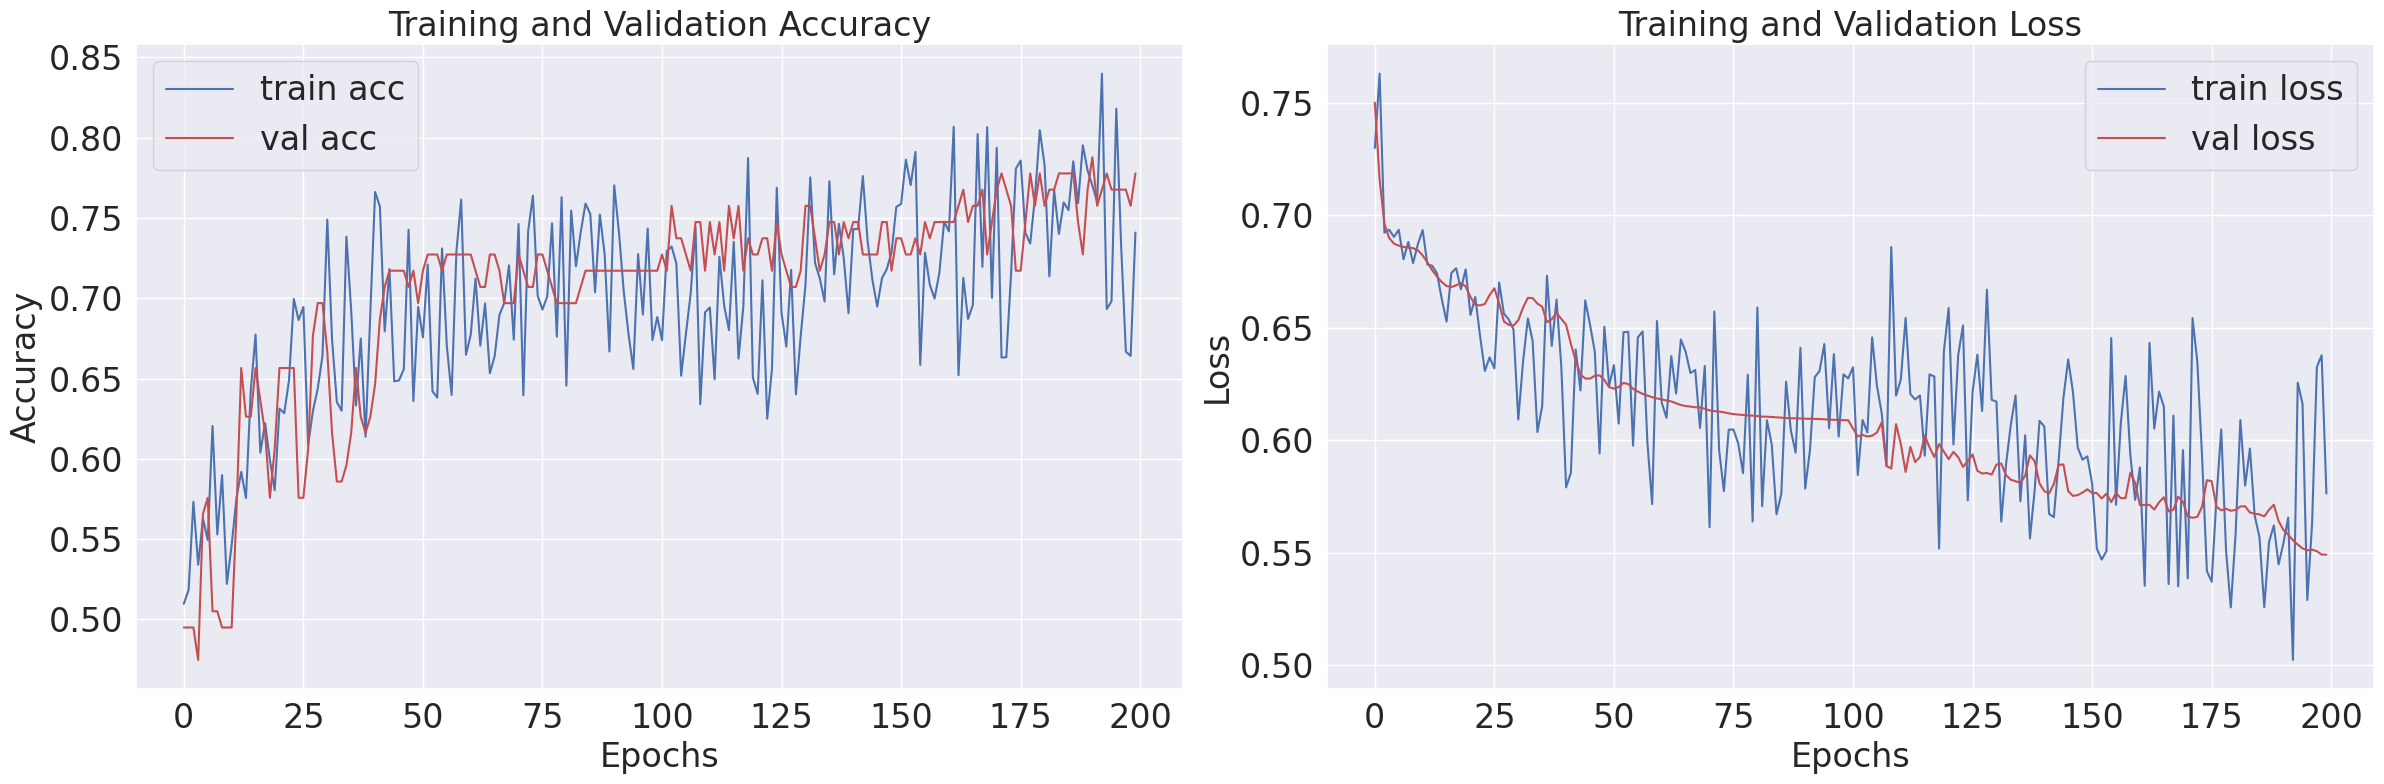

In [12]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


Extracting validation set logits...


Extracting logits: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Extracting test set logits...


Extracting logits: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Calibrating model...

Validation Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 663.24it/s]


Calibrated ROC AUC: 0.8575 [95% CI: 0.7796-0.9215]

Optimal Threshold Analysis (Validation Set):
Optimal threshold: 0.5445
Youden Index: 0.5759
Sensitivity: 0.7800
Specificity: 0.7959
Accuracy: 0.7879
F1-score: 0.7879

Test Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 681.18it/s]


Calibrated ROC AUC: 0.6953 [95% CI: 0.5065-0.8594]

Optimal Threshold Analysis (Test Set):
Using validation threshold: 0.5445
Sensitivity: 0.8333
Specificity: 0.5000
Accuracy: 0.6667
F1-score: 0.7143


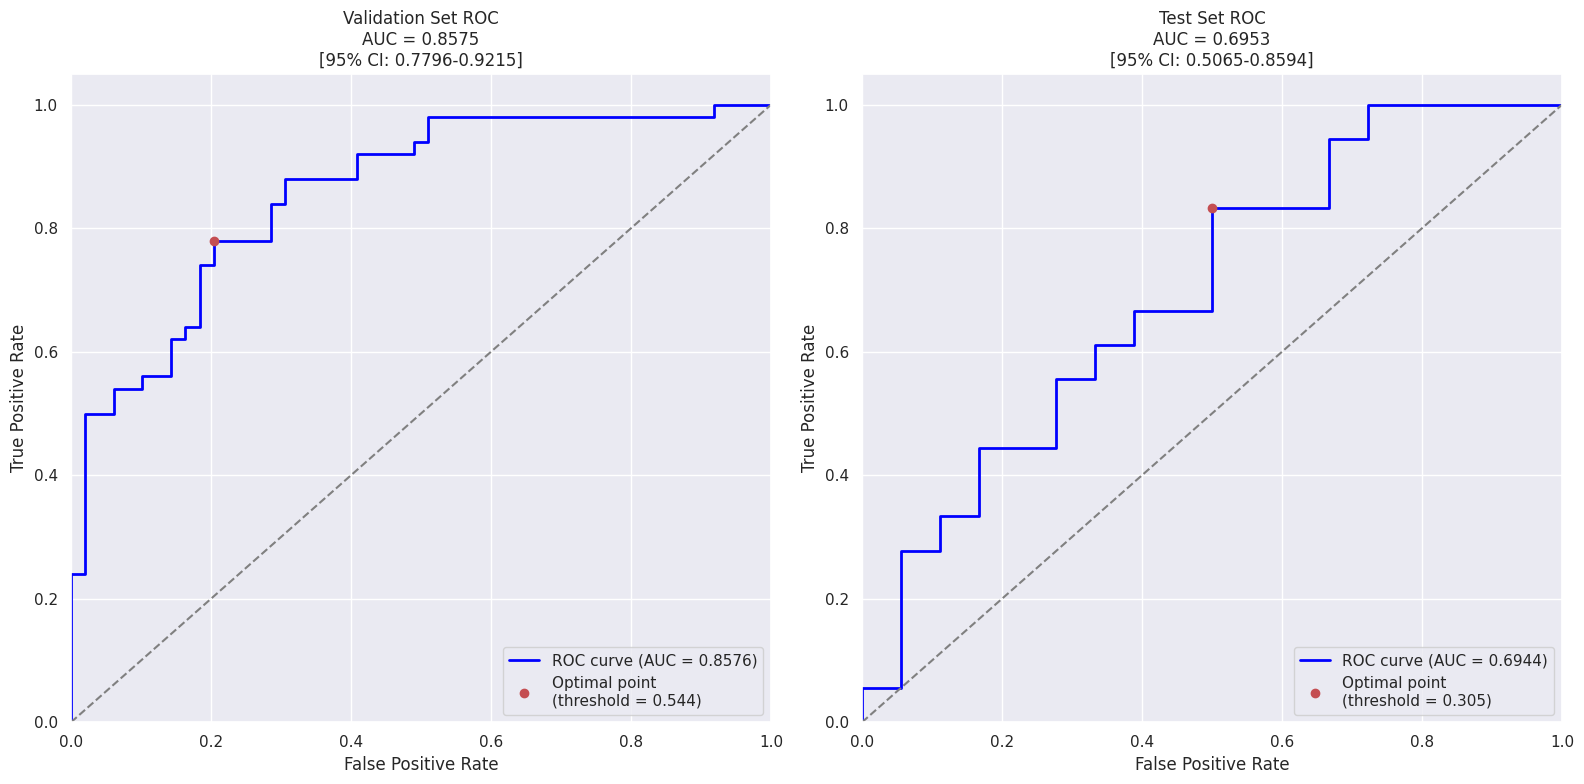

In [13]:
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from tqdm import tqdm
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """
    基本的な評価指標を計算
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score
    }

def calculate_roc_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    ROC-AUCスコアとその信頼区間を計算
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n_bootstraps), desc="Calculating confidence interval"):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    alpha = (1 - confidence_level)
    ci_lower = np.percentile(bootstrapped_scores, alpha/2 * 100)
    ci_upper = np.percentile(bootstrapped_scores, (1 - alpha/2) * 100)

    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def calculate_optimal_threshold(y_true, y_pred_proba):
    """
    Youdenインデックスを用いて最適なカットオフ値を計算
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    youden_indices = tpr - fpr
    optimal_idx = np.argmax(youden_indices)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    youden_index = sensitivity + specificity - 1

    return {
        'threshold': optimal_threshold,
        'youden_index': youden_index,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
        }
    }

def plot_roc_curve_with_optimal_point(y_true, y_pred_proba, title, ax=None):
    """
    ROC曲線と最適カットオフ点をプロット
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    optimal_metrics = calculate_optimal_threshold(y_true, y_pred_proba)
    optimal_threshold = optimal_metrics['threshold']

    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # 既存のaxを使用するか、新しいfigureを作成
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # プロット処理をax.plotに変更
    ax.plot(fpr, tpr, color='blue', lw=2,
            label=f'ROC curve (AUC = {auc_score:.4f})')
    ax.plot(optimal_fpr, optimal_tpr, 'ro',
            label=f'Optimal point\n(threshold = {optimal_threshold:.3f})')

    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

    return optimal_metrics

def extract_logits(model, loader, device):
    """
    モデルからロジットを抽出
    """
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting logits"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

def calibrate_and_evaluate(model, valid_loader, test_loader, device):
    """
    モデルのキャリブレーションと評価を実行
    """
    print("Extracting validation set logits...")
    val_logits, val_targets = extract_logits(model, valid_loader, device)

    print("Extracting test set logits...")
    test_logits, test_targets = extract_logits(model, test_loader, device)

    # プラットスケーリングの設定と実行
    print("Calibrating model...")
    calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
    calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

    calibrator.fit(val_logits, val_targets)
    calibrated_model.fit(val_logits, val_targets)

    # 予測確率の取得
    val_probs = calibrated_model.predict_proba(val_logits)[:, 1]
    test_probs = calibrated_model.predict_proba(test_logits)[:, 1]

    # 検証セットの評価
    print("\nValidation Set Results:")
    val_auc, val_ci_lower, val_ci_upper = calculate_roc_auc_ci(val_targets, val_probs)
    print(f"Calibrated ROC AUC: {val_auc:.4f} [95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # 検証セットの最適カットオフ値を計算
    val_optimal_metrics = calculate_optimal_threshold(val_targets, val_probs)
    print("\nOptimal Threshold Analysis (Validation Set):")
    print(f"Optimal threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Youden Index: {val_optimal_metrics['youden_index']:.4f}")
    print(f"Sensitivity: {val_optimal_metrics['sensitivity']:.4f}")
    print(f"Specificity: {val_optimal_metrics['specificity']:.4f}")
    print(f"Accuracy: {val_optimal_metrics['accuracy']:.4f}")
    print(f"F1-score: {val_optimal_metrics['f1_score']:.4f}")

    # テストセットの評価
    print("\nTest Set Results:")
    test_auc, test_ci_lower, test_ci_upper = calculate_roc_auc_ci(test_targets, test_probs)
    print(f"Calibrated ROC AUC: {test_auc:.4f} [95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    # 検証セットで得られた最適カットオフ値をテストセットに適用
    test_metrics = calculate_optimal_threshold(test_targets, test_probs)
    print("\nOptimal Threshold Analysis (Test Set):")
    print(f"Using validation threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
    print(f"Specificity: {test_metrics['specificity']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1-score: {test_metrics['f1_score']:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    val_optimal_metrics = plot_roc_curve_with_optimal_point(
        val_targets, val_probs,
        f"Validation Set ROC\nAUC = {val_auc:.4f}\n[95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]",
        ax=ax1
    )

    test_optimal_metrics = plot_roc_curve_with_optimal_point(
        test_targets, test_probs,
        f"Test Set ROC\nAUC = {test_auc:.4f}\n[95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]",
        ax=ax2
    )

    plt.tight_layout()
    plt.show()

    # モデルを更新
    model.calibrator = calibrated_model

    return {
        'validation': {
            'auc': val_auc,
            'ci_lower': val_ci_lower,
            'ci_upper': val_ci_upper,
            'optimal_metrics': val_optimal_metrics,
            'predictions': val_probs
        },
        'test': {
            'auc': test_auc,
            'ci_lower': test_ci_lower,
            'ci_upper': test_ci_upper,
            'optimal_metrics': test_optimal_metrics,
            'predictions': test_probs
        }
    }

# メインの実行部分
if __name__ == "__main__":
    # モデルのトレーニング後に実行
    results = calibrate_and_evaluate(model, valid_loader, test_loader, device)

In [14]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'
torch.save(model.state_dict(), model_save_path)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.8576


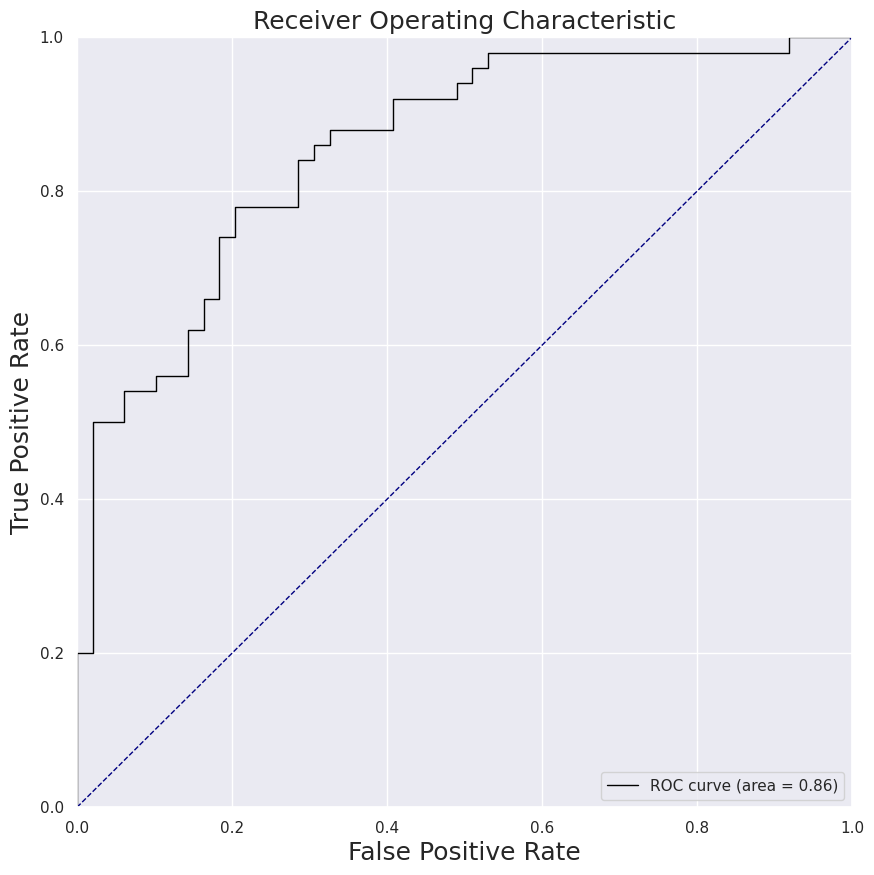

In [16]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [17]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model3.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

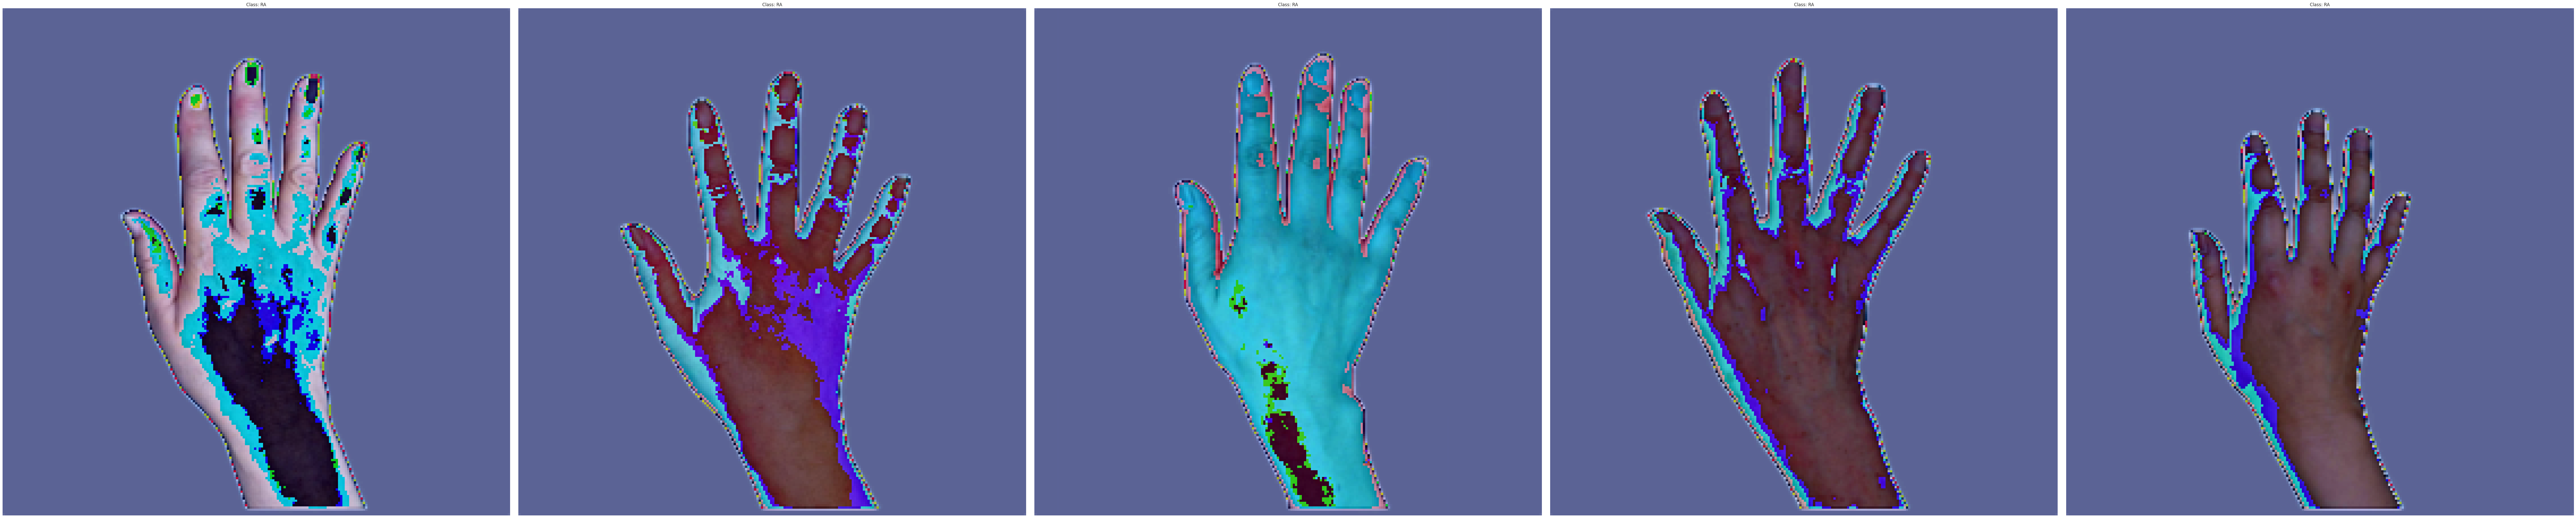

32915

In [18]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

<ipython-input-19-3c2aafc37d31>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.778


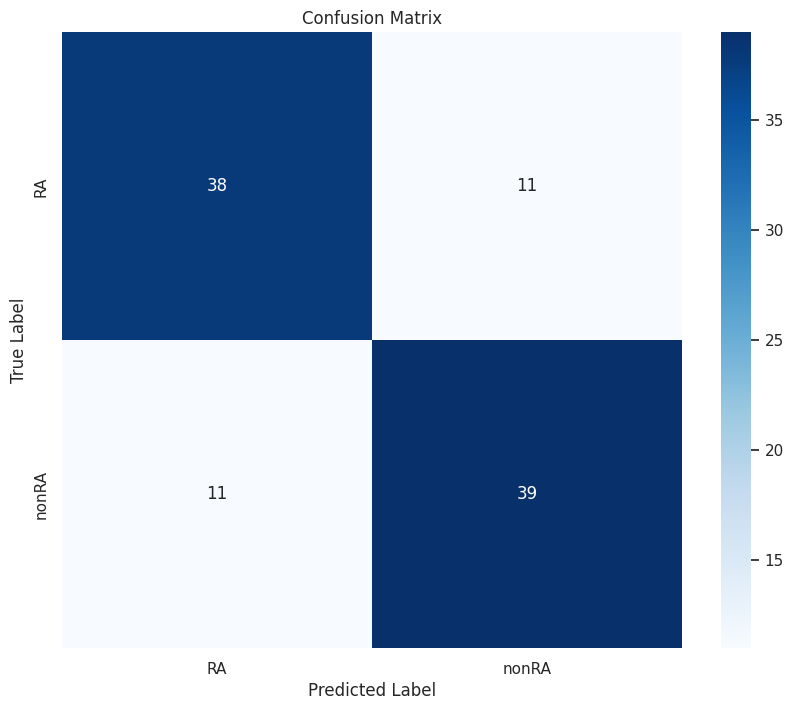

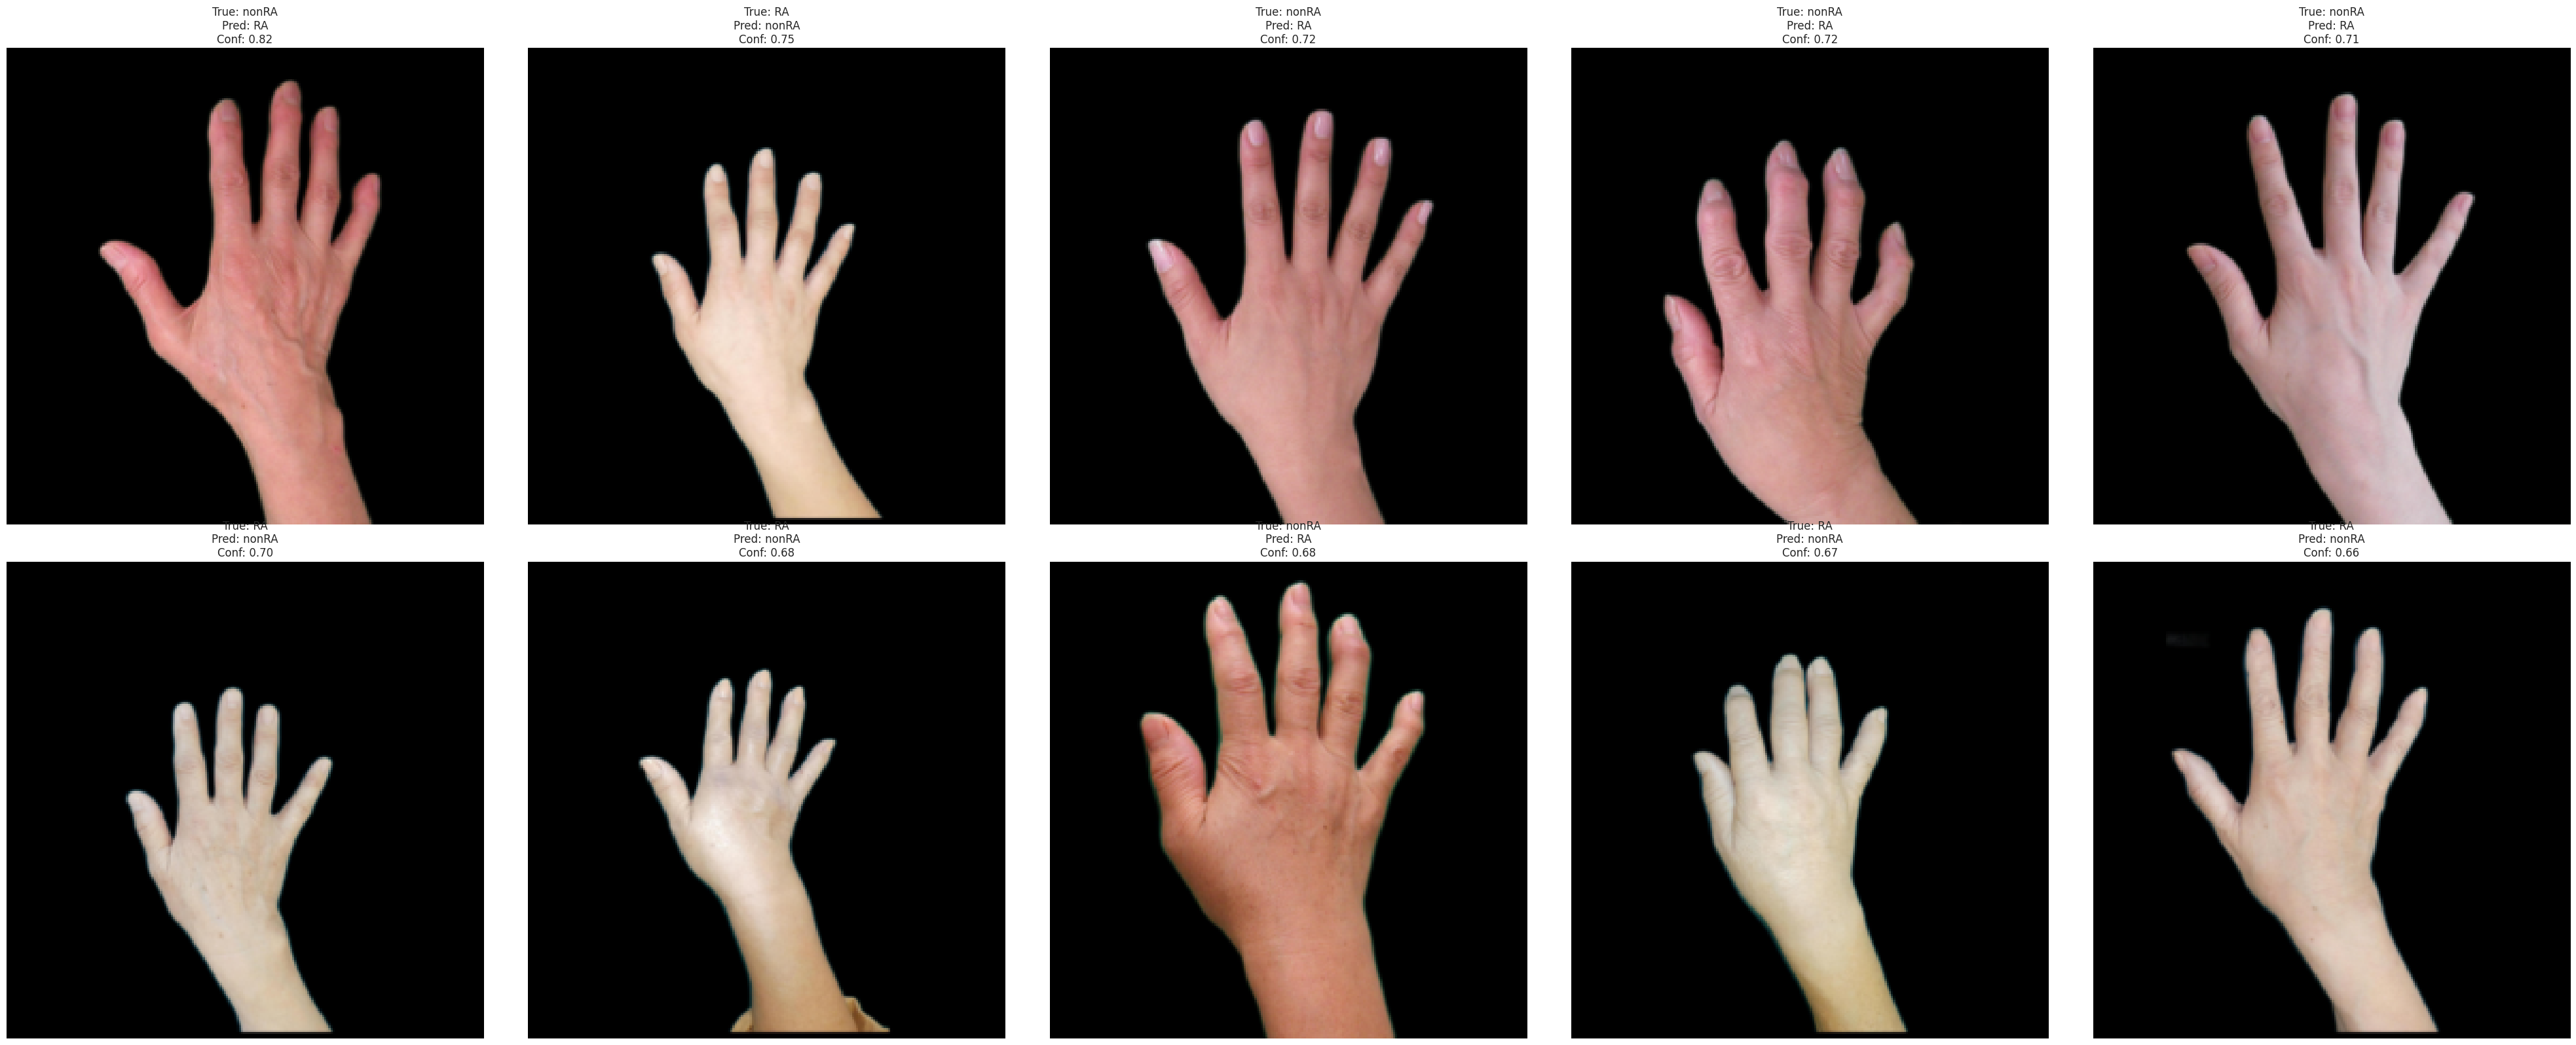

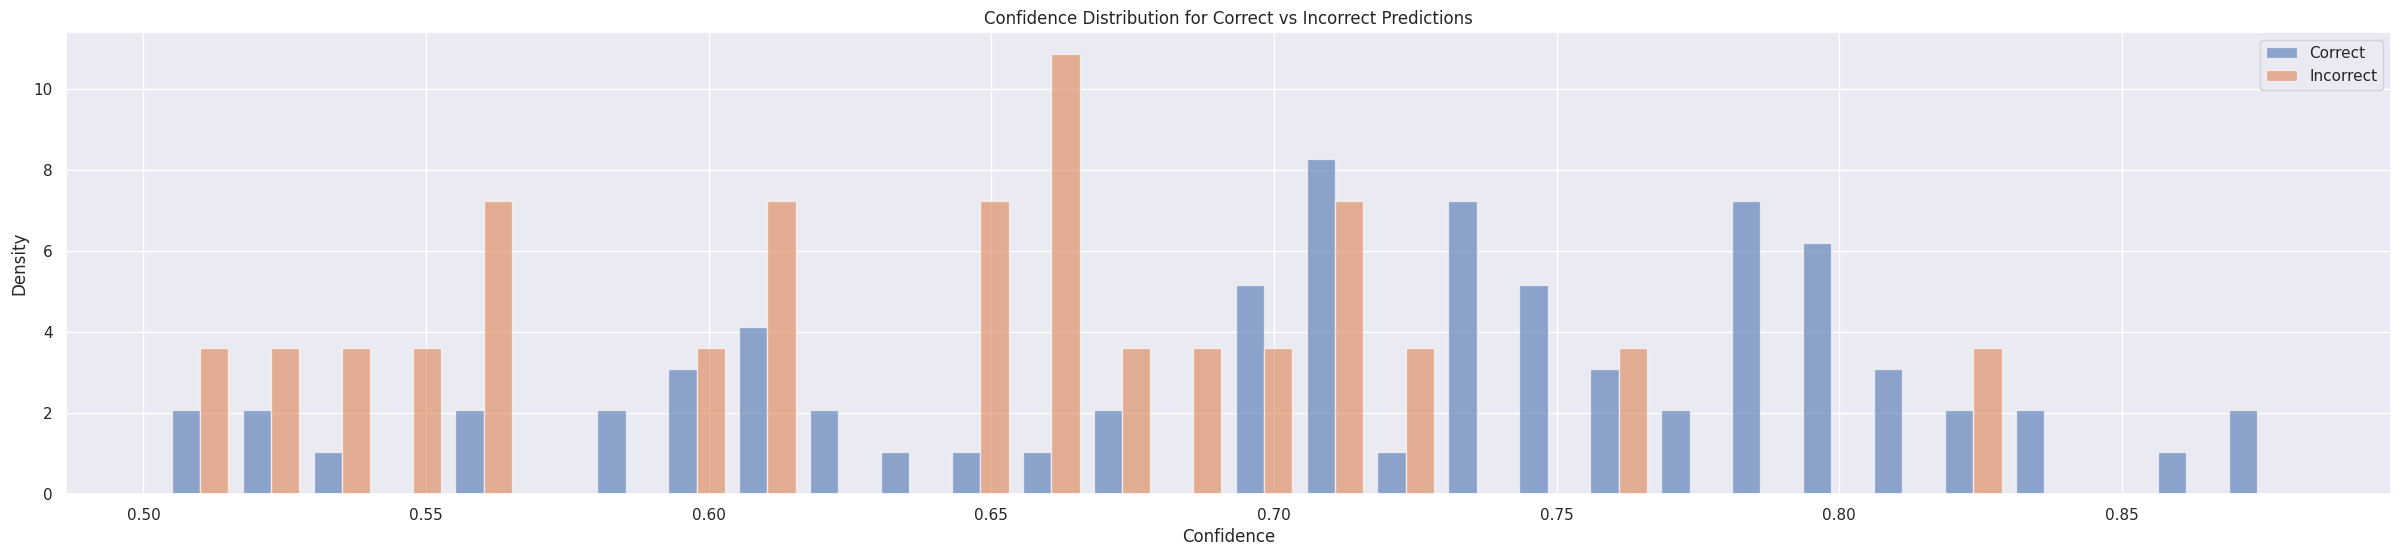


Class RA:
Accuracy: 0.776
Average confidence: 0.705
Samples: 49

Class nonRA:
Accuracy: 0.780
Average confidence: 0.690
Samples: 50


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()